# State-wise Aadhaar Service Demand Analysis

**Objective:**  
This notebook performs a state-level analysis of Aadhaar enrolment and update data to identify patterns in service demand, operational load, and infrastructure stress.

## Datasets Used

- Aadhaar enrolment dataset (age-wise counts)
- Aadhaar demographic update dataset
- Aadhaar biometric update dataset

The datasets are sourced from UIDAI and aggregated to the relevant spatial unit (state or district) for analysis.

## Methodology Overview

- Data filtering and aggregation by geographic unit
- Normalization of region names to ensure administrative consistency
- Construction of ratio-based indicators to capture demand intensity
- Spatial visualization using choropleth maps

Redundant metrics were intentionally excluded to maintain interpretability.

In [19]:
import pandas as pd
from pathlib import Path
import geopandas as gpd
import unicodedata
from rapidfuzz import process, fuzz

BASE_PATH = Path(".")  # notebook is at root

In [20]:
def load_activity_df(folder_name, activity_label):
    """Load and concatenate all CSV files from a folder."""
    dfs = []
    folder_path = BASE_PATH / folder_name

    for csv_file in folder_path.glob("*.csv"):
        df = pd.read_csv(csv_file)
        df["activity_type"] = activity_label
        df["source_file"] = csv_file.name
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)


def normalize_columns(df):
    """Normalize DataFrame column names to lowercase with underscores."""
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df


def drop_numeric_states(df):
    """Remove rows with purely numeric state names."""
    return df[~df["state"].str.fullmatch(r"\d+", na=False)]


def basic_state_cleanup(df):
    """Clean and standardize state name formatting."""
    df["state"] = (
        df["state"]
        .astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
        .str.title()
    )
    return df


def apply_state_map(df, state_map):
    """Apply canonical state name mapping."""
    df["state"] = df["state"].replace(state_map)
    return df


def build_state_lookup(source_states, target_states, threshold=85):
    """Fuzzy match source states to canonical target states using rapidfuzz."""
    lookup = {}
    for s in source_states:
        match, score, _ = process.extractOne(s, target_states, scorer=fuzz.token_sort_ratio)
        lookup[s] = match if score >= threshold else None
    return lookup


def plot_choropleth(gdf, column, title, cmap="YlOrRd", figsize=(10, 12)):
    """Create a choropleth map with consistent styling."""
    ax = gdf.plot(
        column=column,
        cmap=cmap,
        legend=True,
        figsize=figsize,
        edgecolor="black",
        linewidth=0.5
    )
    ax.set_title(title, fontsize=14)
    ax.axis("off")
    return ax

## Loading UIDAI datasets

Here we load all UIDAI CSV files for enrolment, demographic updates, and biometric updates.
Each activity type is kept in a separate dataframe to avoid mixing concepts early on.

This separation helps later when comparing how enrolments differ from update behaviour.

In [21]:
enrolment_df = load_activity_df(
    "api_data_aadhar_enrolment",
    "enrolment"
)

demographic_df = load_activity_df(
    "api_data_aadhar_demographic",
    "demographic_update"
)

biometric_df = load_activity_df(
    "api_data_aadhar_biometric",
    "biometric_update"
)


## Data Quality Check

All datasets contain **no missing values**. The main data quality issue is **inconsistent naming** of states (e.g., Odisha/Orissa, West Bengal variants). This is addressed through canonical state mapping.

In [22]:
# normalize column names (stripping extra spaces and symbols, unicode normalization, etc) 
# dropping states that is made up of only digits
enrolment_df = normalize_columns(enrolment_df)
demographic_df = normalize_columns(demographic_df)
biometric_df = normalize_columns(biometric_df)

enrolment_df = drop_numeric_states(enrolment_df)
demographic_df = drop_numeric_states(demographic_df)
biometric_df = drop_numeric_states(biometric_df)

enrolment_df = basic_state_cleanup(enrolment_df)
demographic_df = basic_state_cleanup(demographic_df)
biometric_df = basic_state_cleanup(biometric_df)

## State Name Standardization (Systematic Approach)

**Step 1:** Define canonical states from GeoJSON  
**Step 2:** Use fuzzy matching to auto-map obvious variants  
**Step 3:** Identify what fuzzy matching missed using set difference  
**Step 4:** Manually correct edge cases and ambiguous matches

In [23]:
# getting state names from mapIndia.json
india_gdf_temp = gpd.read_file("mapIndia.json")
india_gdf_temp = india_gdf_temp.rename(columns={"name": "state"})
india_gdf_temp["state"] = (
    india_gdf_temp["state"]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.title()
)

# states extracted from map
CANONICAL_STATES = {
    "Andaman And Nicobar Islands", "Andhra Pradesh", "Arunachal Pradesh", "Assam",
    "Bihar", "Chandigarh", "Chhattisgarh", "Dadra And Nagar Haveli And Daman And Diu",
    "Delhi", "Goa", "Gujarat", "Haryana", "Himachal Pradesh", "Jammu And Kashmir",
    "Jharkhand", "Karnataka", "Kerala", "Ladakh", "Lakshadweep", "Madhya Pradesh",
    "Maharashtra", "Manipur", "Meghalaya", "Mizoram", "Nagaland", "Odisha",
    "Puducherry", "Punjab", "Rajasthan", "Sikkim", "Tamil Nadu", "Telangana",
    "Tripura", "Uttar Pradesh", "Uttarakhand", "West Bengal"
}

# all unique state names from our datasets
all_states = (
    pd.concat([
        enrolment_df["state"],
        demographic_df["state"],
        biometric_df["state"]
    ])
    .unique()
)

print(f"Found {len(all_states)} unique state names in the data")
print(f"Expected {len(CANONICAL_STATES)} canonical states")

Found 58 unique state names in the data
Expected 36 canonical states


In [24]:
# automating state name match using rapidfuzz by fuzzymatching
fuzzy_lookup = build_state_lookup(all_states, CANONICAL_STATES, threshold=85)

# states that couldnt be matched using fuzzymatching
unmatched_by_fuzzy = [s for s, v in fuzzy_lookup.items() if v is None]

print(f"\nFuzzy matching successfully mapped: {len([v for v in fuzzy_lookup.values() if v is not None])} states")
print(f"Fuzzy matching FAILED on: {len(unmatched_by_fuzzy)} entries")
print(f"\nStates that need manual mapping:")
for state in sorted(unmatched_by_fuzzy):
    print(f"  - '{state}'")
fuzzy_lookup


Fuzzy matching successfully mapped: 42 states
Fuzzy matching FAILED on: 16 entries

States that need manual mapping:
  - 'Balanagar'
  - 'Dadra & Nagar Haveli'
  - 'Dadra And Nagar Haveli'
  - 'Daman & Diu'
  - 'Daman And Diu'
  - 'Darbhanga'
  - 'Jaipur'
  - 'Madanapalle'
  - 'Nagpur'
  - 'Orissa'
  - 'Pondicherry'
  - 'Puttenahalli'
  - 'Raja Annamalai Puram'
  - 'Tamilnadu'
  - 'Uttaranchal'
  - 'Westbengal'


{'Meghalaya': 'Meghalaya',
 'Karnataka': 'Karnataka',
 'Uttar Pradesh': 'Uttar Pradesh',
 'Bihar': 'Bihar',
 'Maharashtra': 'Maharashtra',
 'Haryana': 'Haryana',
 'Rajasthan': 'Rajasthan',
 'Punjab': 'Punjab',
 'Delhi': 'Delhi',
 'Madhya Pradesh': 'Madhya Pradesh',
 'West Bengal': 'West Bengal',
 'Assam': 'Assam',
 'Uttarakhand': 'Uttarakhand',
 'Gujarat': 'Gujarat',
 'Andhra Pradesh': 'Andhra Pradesh',
 'Tamil Nadu': 'Tamil Nadu',
 'Chhattisgarh': 'Chhattisgarh',
 'Jharkhand': 'Jharkhand',
 'Nagaland': 'Nagaland',
 'Manipur': 'Manipur',
 'Telangana': 'Telangana',
 'Tripura': 'Tripura',
 'Mizoram': 'Mizoram',
 'Jammu And Kashmir': 'Jammu And Kashmir',
 'Chandigarh': 'Chandigarh',
 'Sikkim': 'Sikkim',
 'Odisha': 'Odisha',
 'Kerala': 'Kerala',
 'The Dadra And Nagar Haveli And Daman And Diu': 'Dadra And Nagar Haveli And Daman And Diu',
 'Arunachal Pradesh': 'Arunachal Pradesh',
 'Himachal Pradesh': 'Himachal Pradesh',
 'Goa': 'Goa',
 'Dadra And Nagar Haveli And Daman And Diu': 'Dadra And 

### Manual Corrections for Edge Cases

Fuzzy matching can't handle:
- **Legacy names** (Orissa → Odisha, Uttaranchal → Uttarakhand)
- **Merged territories** (Dadra & Daman merged post-2020)
- **Extreme spelling variants** (WESTBENGAL, West Bengli, etc.)
- **City leakage** (city names appearing in state column)

So we manually map these edge cases below:

In [25]:
# fuzzy matching map for state names
STATE_CANONICAL_MAP = fuzzy_lookup.copy()

# manual corrections for what fuzzy matching missed or got wrong
MANUAL_CORRECTIONS = {
    # Legacy state names
    "Orissa": "Odisha",
    "Uttaranchal": "Uttarakhand",
    "Pondicherry": "Puducherry",
    
    # merged territories
    "Dadra & Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
    "Dadra and Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
    "Dadra And Nagar Haveli": "Dadra And Nagar Haveli And Daman And Diu",
    "Daman & Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "Daman and Diu": "Dadra And Nagar Haveli And Daman And Diu",
    "Daman And Diu": "Dadra And Nagar Haveli And Daman And Diu",
    
    
    # City names found in state column (data quality issue)
    "Darbhanga": "Bihar",
    "Balanagar": "Telangana",
    "Jaipur": "Rajasthan",
    "Madanapalle": "Andhra Pradesh",
    "Puttenahalli": "Karnataka",
    "Nagpur": "Maharashtra",
    "Raja Annamalai Puram": "Tamil Nadu"
}

STATE_CANONICAL_MAP.update(MANUAL_CORRECTIONS)

# combined mapping
enrolment_df = apply_state_map(enrolment_df, STATE_CANONICAL_MAP)
demographic_df = apply_state_map(demographic_df, STATE_CANONICAL_MAP)
biometric_df = apply_state_map(biometric_df, STATE_CANONICAL_MAP)

# check if any states still don't match canonical set
final_states = set(pd.concat([
    enrolment_df["state"],
    demographic_df["state"],
    biometric_df["state"]
]).unique())

unmatched_final = final_states - CANONICAL_STATES
if len(unmatched_final) > 0:
    print(f"{len(unmatched_final)} states still not matching canonical set:")
    print(unmatched_final)
else:
    print("All states successfully mapped to canonical names!")

1 states still not matching canonical set:
{None}


## Geospatial Setup & Metric Calculation

Loading the India GeoJSON and aligning state names with our cleaned data.

**Key metrics we'll calculate:**
- **Enrolments**: New Aadhaar cards created
- **Demographic updates**: Address/name/DOB changes  
- **Biometric updates**: Fingerprint/iris corrections
- **Update pressure**: How many updates happen per new enrolment (our main metric!)

In [37]:
# load India map and clean state names to match our data
india_gdf = gpd.read_file("mapIndia.json")
india_gdf = india_gdf.rename(columns={"name": "state"})
india_gdf["state"] = (
    india_gdf["state"]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.title()
)

def strip_accents(text):
    """Remove diacritical marks (accents) from text."""
    if not isinstance(text, str):
        return text
    return "".join(
        c for c in unicodedata.normalize("NFKD", text)
        if not unicodedata.combining(c)
    )

india_gdf["state"] = india_gdf["state"].replace(STATE_CANONICAL_MAP)
india_gdf["state"] = india_gdf["state"].apply(strip_accents)

# aggregate to state level - sum all age groups (not just count rows!)
state_enrol = (
    enrolment_df.groupby("state")[["age_0_5", "age_5_17", "age_18_greater"]]
    .sum()
    .sum(axis=1)
    .rename("enrolments")
)
state_demo = (
    demographic_df.groupby("state")[["demo_age_5_17", "demo_age_17_"]]
    .sum()
    .sum(axis=1)
    .rename("demographic_updates")
)
state_bio = (
    biometric_df.groupby("state")[["bio_age_5_17", "bio_age_17_"]]
    .sum()
    .sum(axis=1)
    .rename("biometric_updates")
)

# Join them together
state_summary = (
    state_enrol.to_frame()
    .join(state_demo, how="left")
    .join(state_bio, how="left")
    .fillna(0)
)

# Calculate our key metrics
# UPDATE PRESSURE = how many updates per enrolment (main metric!)
state_summary["update_pressure"] = (
    (state_summary["demographic_updates"] + state_summary["biometric_updates"])
    / state_summary["enrolments"]
)

state_summary["biometric_intensity"] = (
    state_summary["biometric_updates"] / state_summary["enrolments"]
)

# What % of updates are demographic vs biometric?
state_summary["demographic_share"] = (
    state_summary["demographic_updates"]
    / (state_summary["demographic_updates"] + state_summary["biometric_updates"])
)

state_summary["biometric_share"] = (
    state_summary["biometric_updates"]
    / (state_summary["demographic_updates"] + state_summary["biometric_updates"])
)

# merge with map for visualization
india_summary_gdf = india_gdf.merge(
    state_summary.reset_index(),
    on="state",
    how="left"
)


## Spatial Visualization

### Baseline Distribution Maps
Raw counts show where Aadhaar activity is concentrated geographically.

<Axes: title={'center': 'State-wise Aadhaar Enrolments'}>

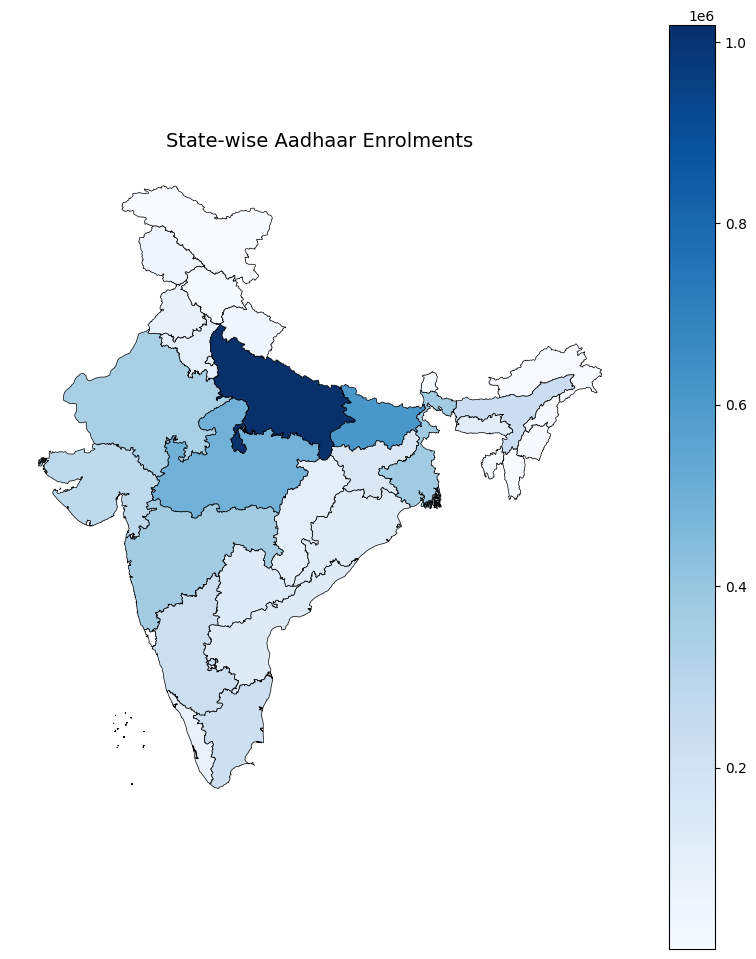

In [27]:
plot_choropleth(india_summary_gdf, "enrolments", "State-wise Aadhaar Enrolments", "Blues")

<Axes: title={'center': 'State-wise Demographic Updates'}>

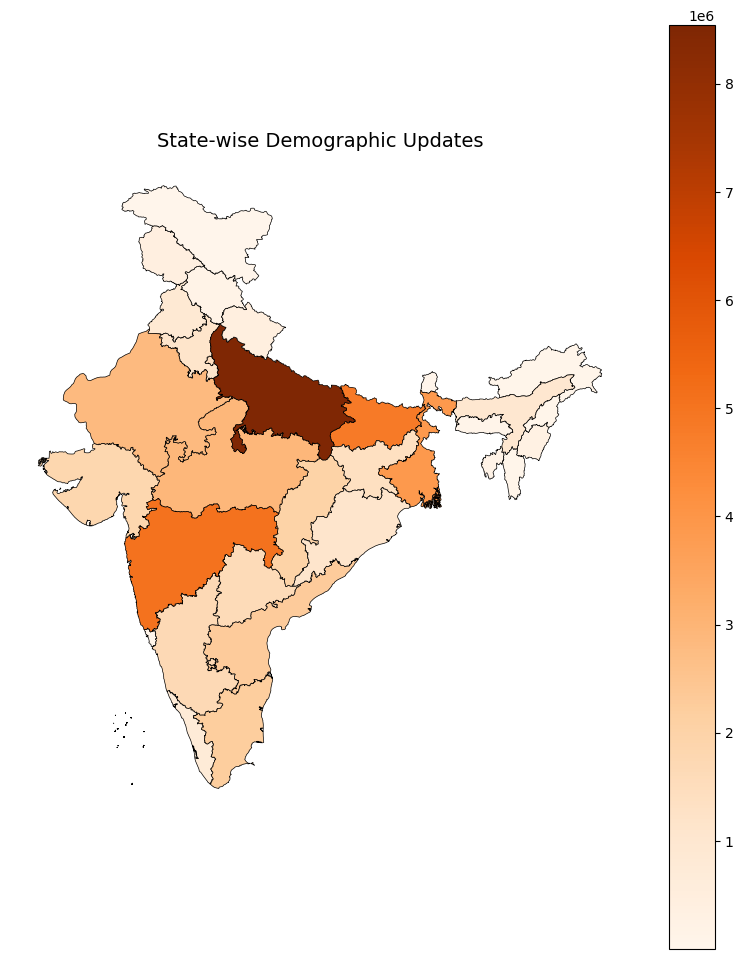

In [28]:
plot_choropleth(india_summary_gdf, "demographic_updates", "State-wise Demographic Updates", "Oranges")

<Axes: title={'center': 'State-wise Biometric Updates'}>

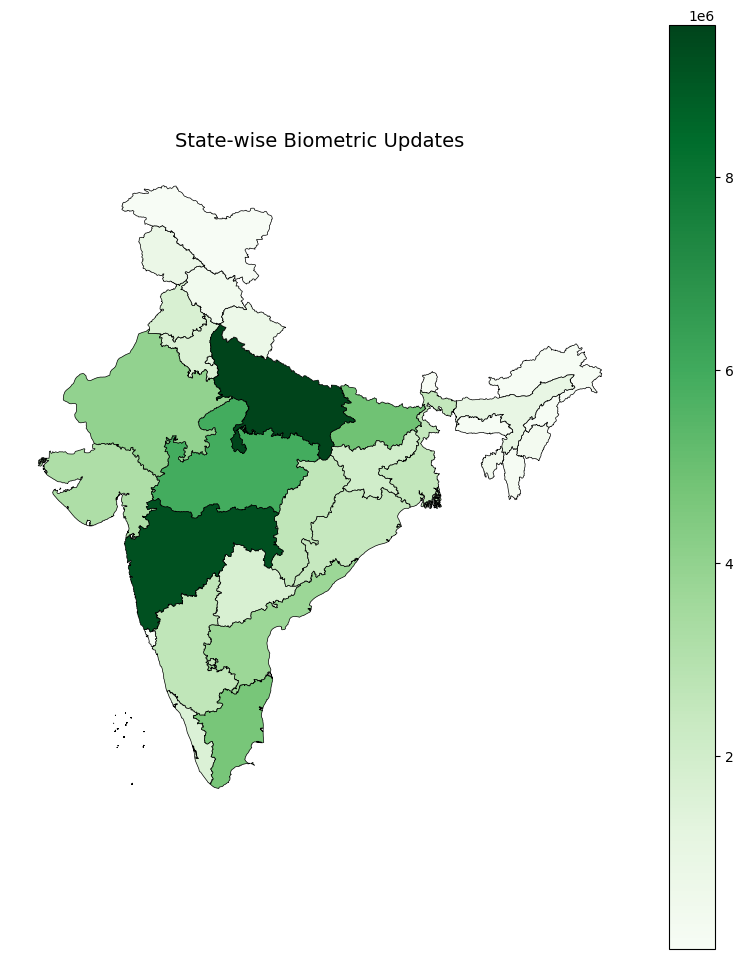

In [29]:
plot_choropleth(india_summary_gdf, "biometric_updates", "State-wise Biometric Updates", "Greens")

### Normalized Metrics
Ratio-based indicators enable fair comparison across states by accounting for scale differences.

<Axes: title={'center': 'Biometric Intensity (per Enrolment)'}>

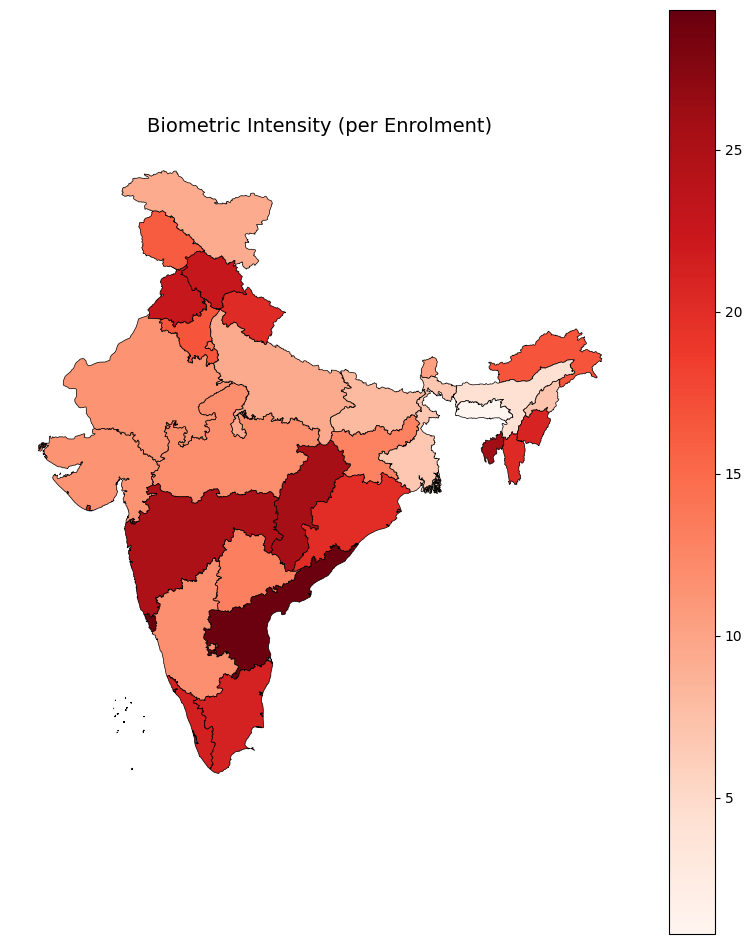

In [30]:
plot_choropleth(india_summary_gdf, "biometric_intensity", "Biometric Intensity (per Enrolment)", "Reds")

<Axes: title={'center': 'Demographic Share of Updates'}>

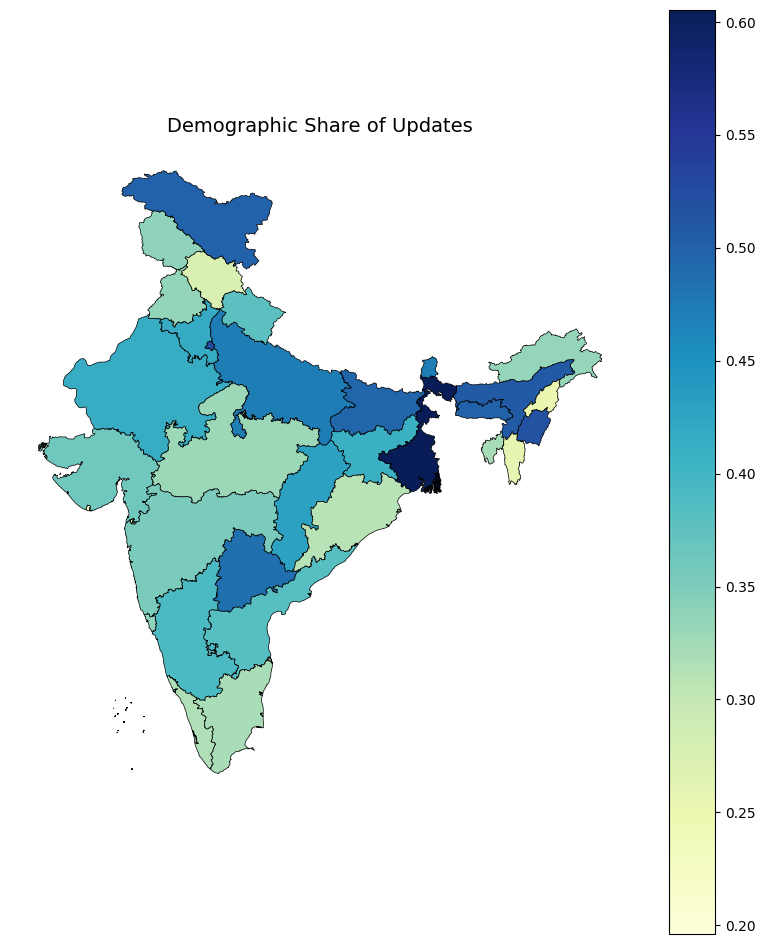

In [31]:
plot_choropleth(india_summary_gdf, "demographic_share", "Demographic Share of Updates", "YlGnBu")

<Axes: title={'center': 'Biometric Share of Updates'}>

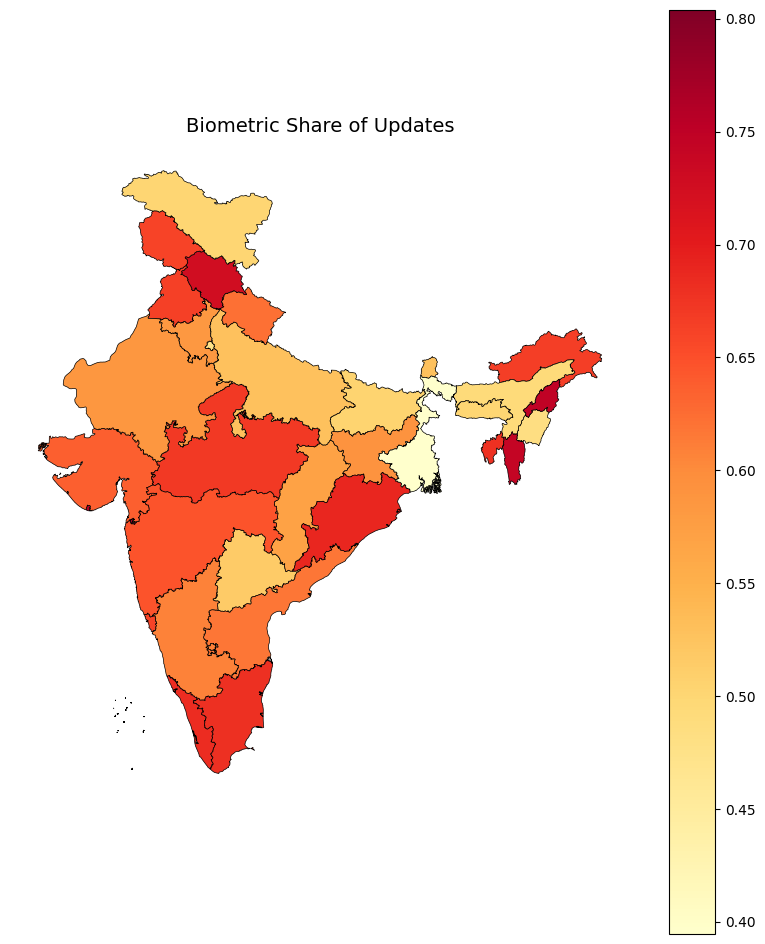

In [32]:
plot_choropleth(india_summary_gdf, "biometric_share", "Biometric Share of Updates", "YlOrRd")

<Axes: title={'center': 'Update Pressure (Updates per Enrolment)'}>

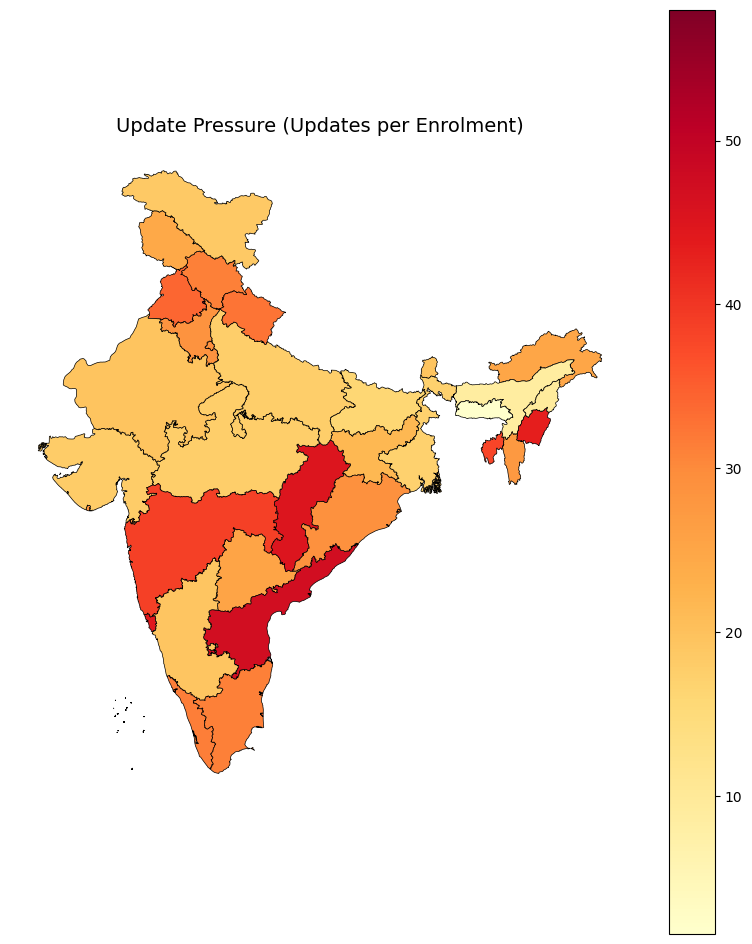

In [33]:
plot_choropleth(india_summary_gdf, "update_pressure", "Update Pressure (Updates per Enrolment)", "YlOrRd")

## Outlier Detection

Using z-scores to find states that behave very differently from the national pattern.  
States with |z-score| > 2 are considered outliers (roughly top/bottom 5%).

In [ ]:
# outlier states (z-score > 2)
state_summary["pressure_zscore"] = (
    (state_summary["update_pressure"] - state_summary["update_pressure"].mean())
    / state_summary["update_pressure"].std()
)

outliers = state_summary.loc[
    state_summary["pressure_zscore"].abs() > 2,
    ["update_pressure", "pressure_zscore"]
].sort_values("pressure_zscore", ascending=False)

outliers

,update_pressure,pressure_zscore
state,,
Chandigarh,57.966581,2.375915
Andaman And Nicobar Islands,54.684932,2.113691
Meghalaya,1.594264,-2.128572


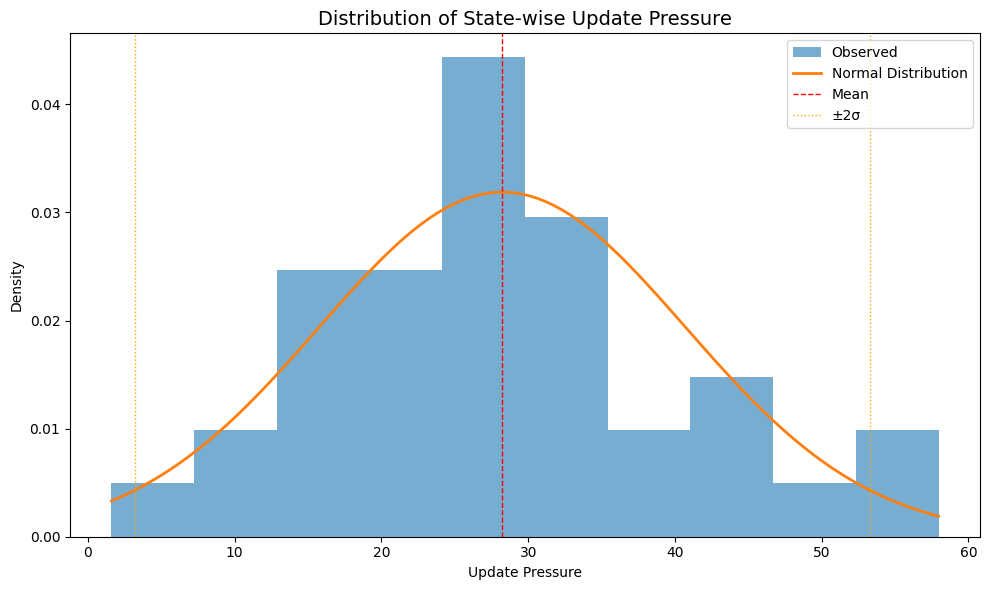

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# normal curve analysis for update pressure
pressure = state_summary["update_pressure"]
mu, sigma = pressure.mean(), pressure.std()

plt.figure(figsize=(10, 6))
plt.hist(pressure, bins=10, density=True, alpha=0.6, label="Observed")

x = np.linspace(pressure.min(), pressure.max(), 100)
normal_curve = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, normal_curve, linewidth=2, label="Normal Distribution")

plt.axvline(mu, color="red", linestyle="--", linewidth=1, label="Mean")
plt.axvline(mu + 2*sigma, color="orange", linestyle=":", linewidth=1, label="±2σ")
plt.axvline(mu - 2*sigma, color="orange", linestyle=":", linewidth=1)

plt.title("Distribution of State-wise Update Pressure", fontsize=14)
plt.xlabel("Update Pressure")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()